In [2]:
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/utils/')
from data_loading import *
from hit import Hit
from track3D import Track3D
from track import Track
from parameters import *
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import sys
from tqdm import tqdm
import pickle
import scienceplots
plt.style.use(['science', 'grid', 'bright'])
plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Computer Modern Roman",
    'text.latex.preamble': [r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{siunitx}'],
    'figure.dpi': 140,
    'font.size': 14,
    'axes.grid': True
})


In [3]:
# later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing
file_path = '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/geant4/data_fit_test.root'

branch_list = ['E', 'Edep', 'pdg', 'EcalEdep',
               'layerID', 'barID', 'Nhits', 'tx', 'ty', 'x0', 'y0', 'n_sec', 'ProcessID']
with uproot.open(file_path) as tree:
        hits_dict = tree['events'].arrays(branch_list, library="np")

df_hits = pd.DataFrame.from_dict(hits_dict)

In [4]:
def get_hits(row):
    return [[row['barID'][i], row['layerID'][i], row['EcalEdep'][i]] for i in range(len(row['barID'])) if row['EcalEdep'][i] > 0]

def create_tracks(df, plot=False):
    tracks = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        layers = row['layerID']
        bars = row['barID']
        Edep = row['EcalEdep']
        hits = get_hits(row)
        hitsX = [Hit([bar, (layer-1)/2 + 1], True, 0, 0, e) for (bar, layer, e) in hits if layer % 2 == 1]
        hitsY = [Hit([bar, layer/2 + 1], False, 0, 0, e) for (bar, layer, e) in hits if layer % 2 == 0]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            # get track parameters
            track = Track3D()
            track.x = Track(hitsX)
            track.y = Track(hitsY)
            tracks.append(track)

    return tracks


In [5]:
# tracks = create_tracks(df_hits.head(1000))
# with open('hough_para_GEANT_tracks.pkl', 'wb') as outp:
#     pickle.dump(tracks, outp, pickle.HIGHEST_PROTOCOL)
    
with open('hough_para_GEANT_tracks.pkl', 'rb') as inp:
    tracks = pickle.load(inp)
total_events = len(tracks)

In [6]:
from timeit import default_timer as timer
from other_hough_transform import old_method_tracks
cell_sampling = [1, 5, 10, 15, 20]
angle_sampling = [50, 100, 150, 200, 250]

# ratios_for_cells = []
# timings_for_cells = []
# for_cells_angle_sampling = np.linspace(10, 250, 60, dtype = int)
# for cs in tqdm(cell_sampling, desc = 'for cell sampling', position=0, leave = True):
#     ratios = []
#     timings = []
#     for a in tqdm(for_cells_angle_sampling, desc = 'angle sampling', position=1, leave = False):
#         start = timer()
#         for t in tracks: #tqdm(tracks, desc = 'tracks', leave = False, position=2):
#             t.find_track(cs, a)
#         end = timer()
#         ratios.append(len([tr for tr in tracks if tr.is_good_2D_fit()]) / total_events)
#         timings.append((end - start) * 1000 / total_events)
#     ratios_for_cells.append(ratios)
#     timings_for_cells.append(timings)
# with open('hough_para_GEANT_for_cells2.pkl', 'wb') as outp:
#     pickle.dump([cell_sampling, ratios_for_cells, timings_for_cells, for_cells_angle_sampling], outp, pickle.HIGHEST_PROTOCOL)
    
# ratios_for_angles = []
# timings_for_angles = []
# for_angles_cell_sampling = np.linspace(1, 20, 20, dtype = int)
# for a in tqdm(angle_sampling, desc = 'for angle sampling', position=0, leave = True):
#     ratios = []
#     timings = []
#     for cs in tqdm(for_angles_cell_sampling, desc = 'cell sampling', position=1, leave = False):
#         start = timer()
#         for t in tracks: #tqdm(tracks, desc = 'tracks', leave = False, position=2):
#             t.find_track(cs, a)
#         end = timer()
#         ratios.append(len([tr for tr in tracks if tr.is_good_2D_fit()]) / total_events)
#         timings.append((end - start) * 1000 / total_events)
#     ratios_for_angles.append(ratios)
#     timings_for_angles.append(timings)
# with open('hough_para_GEANT_for_angles2.pkl', 'wb') as outp:
#     pickle.dump([angle_sampling, ratios_for_angles, timings_for_angles, for_angles_cell_sampling], outp, pickle.HIGHEST_PROTOCOL)
    
## old Hough transform method
start = timer()
old_tracks = []
for t in tqdm(tracks, desc = 'old method', leave = True):
    hitsX = t.x.hits.copy()
    hitsY = t.y.hits.copy()
    outx, tx, index_x = old_method_tracks(hitsX)
    outy, ty, index_y = old_method_tracks(hitsY)
    old_t = Track3D()
    old_t.x = Track(hitsX, tx, outx, 0)
    old_t.y = Track(hitsY, ty, outy, 0)
    old_tracks.append(old_t)
stop = timer()
ratio_for_old = len([tr for tr in old_tracks if tr.is_good_2D_fit()]) / total_events
timing_for_old = (stop - start) * 1000 / total_events

## Kalman filter method
start = timer()
for t in tqdm(tracks, desc = 'Kalman', leave = True):
    t.kalman_filter()
stop = timer()
ratio_Kalman = len([tr for tr in tracks if tr.is_good_2D_fit()]) / total_events
timing_Kalman = (stop - start) * 1000 / total_events


with open('hough_para_GEANT_for_cells2.pkl', 'rb') as inp:
    [cell_sampling, ratios_for_cells, timings_for_cells, for_cells_angle_sampling] = pickle.load(inp)
with open('hough_para_GEANT_for_angles2.pkl', 'rb') as inp:
    [angle_sampling, ratios_for_angles, timings_for_angles, for_angles_cell_sampling] = pickle.load(inp)

Kalman: 100%|██████████| 982/982 [00:01<00:00, 822.92it/s]


Kalman efficiency = 0.003


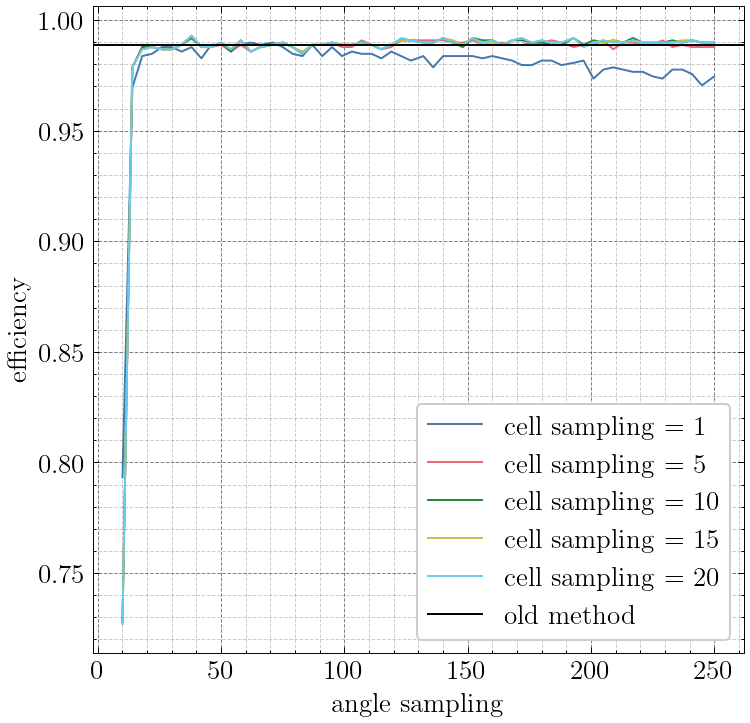

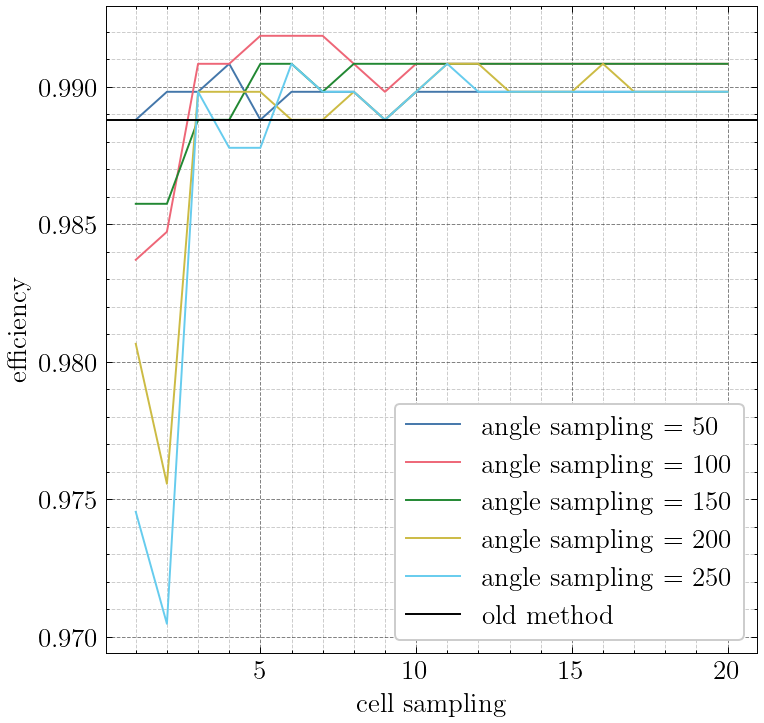

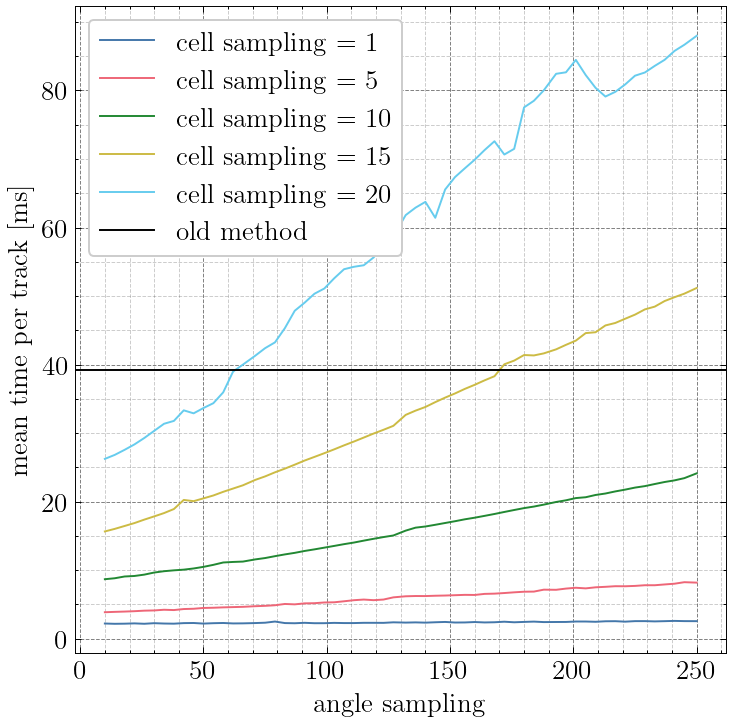

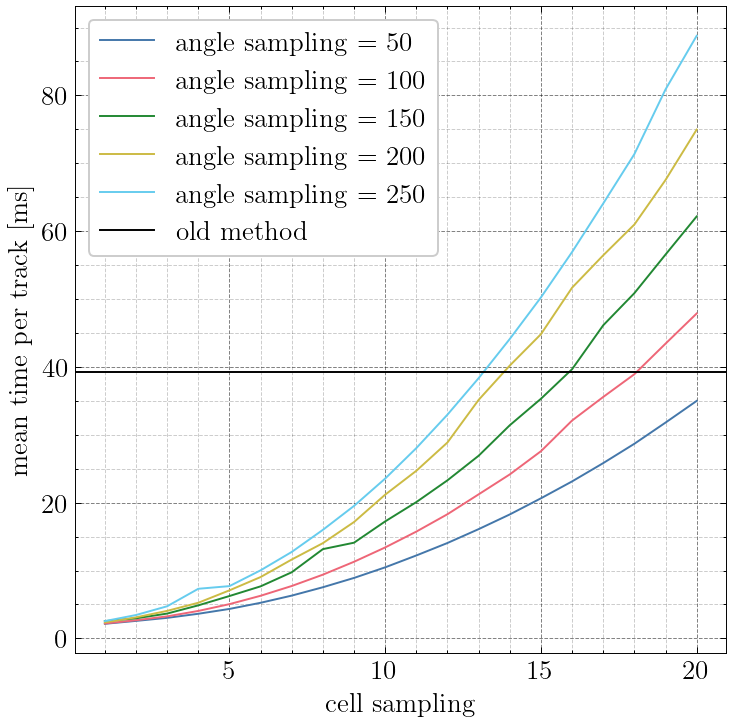

In [7]:
print('Kalman efficiency = {:.3f}'.format(ratio_Kalman))
# fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.figure(figsize=(6, 6))
for i in range(len(cell_sampling)):
    plt.plot(for_cells_angle_sampling, ratios_for_cells[i], label = 'cell sampling = {}'.format(cell_sampling[i]))
plt.axhline(ratio_for_old, 0, 1, c = 'k', label = 'old method')
plt.xlabel('angle sampling')
plt.ylabel('efficiency')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.2)
plt.legend()
plt.savefig('../../../figs/hough_parameters_GEANT_ratio_for_cells.pdf')

plt.figure(figsize=(6, 6))
for i in range(len(angle_sampling)):
    plt.plot(for_angles_cell_sampling, ratios_for_angles[i], label = 'angle sampling = {}'.format(angle_sampling[i]))
plt.axhline(ratio_for_old, 0, 1, c = 'k', label = 'old method')
plt.xlabel('cell sampling')
plt.ylabel('efficiency')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.2)
plt.legend()
plt.savefig('../../../figs/hough_parameters_GEANT_ratio_for_angles.pdf')

# fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.figure(figsize=(6, 6))
for i in range(len(cell_sampling)):
    plt.plot(for_cells_angle_sampling, timings_for_cells[i], label = 'cell sampling = {}'.format(cell_sampling[i]))
plt.axhline(timing_for_old, 0, 1, color = 'k', label = 'old method')
plt.xlabel('angle sampling')
plt.ylabel('mean time per track [ms]')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.2)
plt.legend()
plt.savefig('../../../figs/hough_parameters_GEANT_timing_for_cells.pdf')

plt.figure(figsize=(6, 6))
for i in range(len(angle_sampling)):
    plt.plot(for_angles_cell_sampling, timings_for_angles[i], label = 'angle sampling = {}'.format(angle_sampling[i]))
plt.axhline(timing_for_old, 0, 1, color = 'k', label = 'old method')
plt.xlabel('cell sampling')
plt.ylabel('mean time per track [ms]')
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.2)
plt.legend()
plt.savefig('../../../figs/hough_parameters_GEANT_timing_for_angles.pdf')
